In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
BASE_PATH = "/content/drive/MyDrive/COCO"
IMG_PATH = f"{BASE_PATH}/train2017"
ANN_PATH = f"{BASE_PATH}/annotations/captions_train2017.json"

In [20]:
ANN_PATH = "/content/annotations/captions_train2017.json"

In [4]:
import os
print(os.path.exists(ANN_PATH))  # must be True

True


In [17]:
import json

with open(ANN_PATH, "r") as f:
    coco_data = json.load(f)

captions = []

for ann in coco_data["annotations"]:
    cap = ann["caption"].lower().strip()
    cap = "<start> " + cap + " <end>"
    captions.append(cap)

In [67]:
print("Total captions:", len(captions))
print("Sample:", captions[0])

Total captions: 591753
Sample: <start> a bicycle replica with a clock as the front wheel. <end>


**CNN** **ENCODER**

In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet')
base_model.trainable = False

encoder = Model(
    base_model.input,
    base_model.layers[-2].output
)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Bahdanau Attention**

In [8]:
import tensorflow as tf

In [9]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        """
        features: (batch_size, num_features, embedding_dim)
        hidden:   (batch_size, units)
        """

        # Expand hidden state for addition
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # Score calculation
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # Attention weights
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Context vector
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [10]:
class RNNDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super().__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        # 🔑 IMPORTANT: return_state = False
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            recurrent_initializer="glorot_uniform"
        )

        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # Attention
        context_vector, attention_weights = self.attention(features, hidden)

        # Embedding
        x = self.embedding(x)

        # Concatenate context + embedding
        x = tf.concat(
            [tf.expand_dims(context_vector, 1), x],
            axis=-1
        )

        # 🔑 GRU RETURNS ONLY ONE TENSOR NOW
        output = self.gru(x, initial_state=hidden)

        # Use last timestep as new hidden state
        state = output[:, -1, :]

        # Fully connected
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [11]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img

In [12]:
import json

with open(ANN_PATH, "r") as f:
    coco = json.load(f)

In [13]:
image_id_to_filename = {
    img["id"]: img["file_name"]
    for img in coco["images"]
}

In [14]:
ann = coco["annotations"][0]

image_id = ann["image_id"]
filename = image_id_to_filename[image_id]

image_path = f"{IMG_PATH}/{filename}"
print(image_path)

/content/drive/MyDrive/COCO/train2017/000000203564.jpg


In [15]:
raw_captions = []
image_paths = []

for ann in coco["annotations"]:
    img_id = ann["image_id"]
    filename = image_id_to_filename[img_id]

    image_paths.append(f"{IMG_PATH}/{filename}")
    raw_captions.append(
        "startseq " + ann["caption"].lower().strip() + " endseq"
    )

In [69]:
tokenizer = Tokenizer(oov_token="unk")
tokenizer.fit_on_texts(raw_captions)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

Vocab size: 27552


In [68]:
embedding_dim = 256
units = 512

decoder = RNNDecoder(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    units=units
)

In [70]:
assert "tokenizer" in globals()
assert "vocab_size" in globals()
print("Tokenizer & vocab_size are ready")

Tokenizer & vocab_size are ready


**CNN Encoder (Image → Feature Map)**

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

**Load Pretrained CNN**

In [ ]:
base_model = InceptionV3(
    weights="imagenet",
    include_top=False
)

base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**Build encoder model**

In [24]:
encoder = Model(
    inputs=base_model.input,
    outputs=base_model.output
)

**Image Preprocessing**

In [25]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img

In [ ]:
%cd /content/drive/MyDrive/COCO

/content/drive/MyDrive/COCO


In [ ]:
!mkdir -p /content/drive/MyDrive/COCO
%cd /content/drive/MyDrive/COCO

/content/drive/MyDrive/COCO


In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/00

In [ ]:
len(os.listdir("/content/drive/MyDrive/COCO/train2017"))

118287

In [71]:
image_paths = []
caption_sequences = []

for ann in coco["annotations"]:
    image_id = ann["image_id"]
    filename = image_id_to_filename[image_id]
    img_path = f"{IMG_PATH}/{filename}"

    caption = "<start> " + ann["caption"].lower().strip() + " <end>"
    seq = tokenizer.texts_to_sequences([caption])[0]

    image_paths.append(img_path)
    caption_sequences.append(seq)

In [72]:
max_length = max(len(seq) for seq in caption_sequences)

In [73]:
image_paths = []
caption_sequences = []

for ann in coco["annotations"]:
    caption = ann["caption"].lower().strip()
    caption = "<start> " + caption + " <end>"

    seq = tokenizer.texts_to_sequences([caption])[0]

    # 🔴 IMPORTANT FILTER
    if len(seq) < 2:
        continue

    image_id = ann["image_id"]
    filename = image_id_to_filename[image_id]
    img_path = f"{IMG_PATH}/{filename}"

    image_paths.append(img_path)
    caption_sequences.append(seq)

In [29]:
# Clear contaminated variables
del caption_sequences
del image_paths

In [74]:
image_paths = []
caption_sequences = []

for ann in coco["annotations"]:
    caption = ann["caption"].lower().strip()
    caption = "<start> " + caption + " <end>"

    seq = tokenizer.texts_to_sequences([caption])[0]

    # STRICT FILTER
    if not seq or len(seq) < 2:
        continue

    image_id = ann["image_id"]
    filename = image_id_to_filename[image_id]
    img_path = f"{IMG_PATH}/{filename}"

    image_paths.append(img_path)
    caption_sequences.append(seq)

In [31]:
import tensorflow as tf
import json, os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [32]:
BASE_PATH = "/content/drive/MyDrive/COCO"
IMG_PATH = f"{BASE_PATH}/train2017"
ANN_PATH = f"{BASE_PATH}/annotations/captions_train2017.json"

In [33]:
with open(ANN_PATH, "r") as f:
    coco = json.load(f)

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in caption_sequences)

caption_sequences = pad_sequences(
    caption_sequences,
    maxlen=max_length,
    padding="post",
    truncating="post"
)

In [35]:
clean_sequences = []
clean_image_paths = []

for seq, img_path in zip(caption_sequences, image_paths):
    if seq is None:
        continue
    if len(seq) < 2:
        continue
    if any(x is None for x in seq):
        continue

    clean_sequences.append(seq)
    clean_image_paths.append(img_path)

caption_sequences = clean_sequences
image_paths = clean_image_paths

In [76]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 🔑 Force all sequences to be clean Python lists of ints
clean_sequences = []

for seq in caption_sequences:
    if seq is None:
        continue
    if len(seq) < 2:
        continue
    clean_sequences.append([int(x) for x in seq])

caption_sequences = clean_sequences

# Compute max length safely
max_length = max(len(seq) for seq in caption_sequences)

# Pad
caption_sequences = pad_sequences(
    caption_sequences,
    maxlen=max_length,
    padding="post",
    truncating="post",
    dtype="int32"
)

In [ ]:
print(len(image_paths))
print(len(caption_sequences))
print(type(caption_sequences))

591753
591753
<class 'list'>


In [ ]:
import os

print(os.path.exists("/content/drive/MyDrive/COCO"))
print(os.path.exists("/content/drive/MyDrive/COCO/annotations"))
print(os.path.exists("/content/drive/MyDrive/COCO/annotations/captions_train2017.json"))

True
True
True


In [ ]:
%cd /content/drive/MyDrive/COCO

/content/drive/MyDrive/COCO


In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-12-22 12:00:33--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.216.49, 52.217.67.68, 16.15.192.250, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.216.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  6.79MB/s    in 43s     

2025-12-22 12:01:16 (5.58 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
import os

print(os.path.exists("/content/drive/MyDrive/COCO/annotations"))
print(os.path.exists("/content/drive/MyDrive/COCO/annotations/captions_train2017.json"))

True
True


In [37]:
BASE_PATH = "/content/drive/MyDrive/COCO"
IMG_PATH = f"{BASE_PATH}/train2017"
ANN_PATH = f"{BASE_PATH}/annotations/captions_train2017.json"

In [38]:
import json

with open(ANN_PATH, "r") as f:
    coco = json.load(f)

print("Images:", len(coco["images"]))
print("Captions:", len(coco["annotations"]))

Images: 118287
Captions: 591753


In [39]:
image_id_to_filename = {
    img["id"]: img["file_name"]
    for img in coco["images"]
}

In [40]:
raw_captions = []
raw_image_paths = []

for ann in coco["annotations"]:
    image_id = ann["image_id"]
    filename = image_id_to_filename[image_id]
    img_path = f"{IMG_PATH}/{filename}"

    caption = "startseq " + ann["caption"].lower().strip() + " endseq"


    raw_captions.append(caption)
    raw_image_paths.append(img_path)

print(len(raw_captions), len(raw_image_paths))

591753 591753


In [41]:
tokenizer = Tokenizer(oov_token="unk")
tokenizer.fit_on_texts(raw_captions)

vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

Vocab size: 27552


In [42]:
caption_sequences = tokenizer.texts_to_sequences(raw_captions)

In [43]:
clean_sequences = []
clean_image_paths = []

for seq, img_path in zip(caption_sequences, image_paths):
    if not seq:
        continue
    if len(seq) < 2:
        continue

    clean_sequences.append(seq)
    clean_image_paths.append(img_path)

caption_sequences = clean_sequences
image_paths = clean_image_paths

print(len(caption_sequences), len(image_paths))

0 0


In [77]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in caption_sequences)

caption_sequences = pad_sequences(
    caption_sequences,
    maxlen=max_length,
    padding="post",
    truncating="post",
    dtype="int32"
)

In [78]:
print(type(caption_sequences))
print(caption_sequences.shape)
print(caption_sequences.dtype)

<class 'numpy.ndarray'>
(591753, 52)
int32


In [46]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

def load_image_tf(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img

In [47]:
def map_func(img_path, caption):
    img = load_image_tf(img_path)
    return img, caption

In [48]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

def load_image_tf(img_path):
    # Read image file
    img = tf.io.read_file(img_path)

    # Decode JPEG
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize for InceptionV3
    img = tf.image.resize(img, (299, 299))

    # Preprocess (scale pixels as InceptionV3 expects)
    img = preprocess_input(img)

    return img

In [79]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

dataset = tf.data.Dataset.from_tensor_slices(
    (image_paths, caption_sequences)
)

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.map(
    lambda x, y: (load_image_tf(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [80]:
img, cap = next(iter(dataset))
print(img.shape, cap.shape)

(16, 299, 299, 3) (16, 52)


In [50]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction="none"
)

def loss_function(real, pred):
    # Mask padding (0)
    mask = tf.math.not_equal(real, 0)
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)


In [51]:
optimizer = tf.keras.optimizers.Adam()

In [53]:
print('start' in tokenizer.word_index)
print('<start>' in tokenizer.word_index)

True
False


In [54]:
total_loss = tf.constant(0.0)

In [55]:
TOTAL_SPLITS = 5
BATCHES_PER_SPLIT = 1850 // TOTAL_SPLITS  # ≈ 370

In [56]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("❌ Error enabling memory growth:", e)
else:
    print("⚠️ No GPU found")

❌ Error enabling memory growth: Physical devices cannot be modified after being initialized


In [ ]:
tf.config.experimental.get_memory_growth(gpus[0])
print('yes')

yes


In [58]:
# FORCE overwrite train_step (no autograph, no cache)
def train_step(img_tensor, target):
    loss = 0.0

    batch_size = tf.shape(target)[0]
    hidden = decoder.reset_state(batch_size=batch_size)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)  # NO reshape here

        dec_input = tf.expand_dims(
            tf.fill([batch_size], tokenizer.word_index['startseq']),
            1
        )

        for t in range(1, max_length):
            predictions, hidden, _ = decoder(
                dec_input, features, hidden
            )

            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1)

    total_loss = loss / tf.cast(max_length, tf.float32)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(total_loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return total_loss

In [59]:
import inspect
print(inspect.getsource(train_step))

def train_step(img_tensor, target):
    loss = 0.0

    batch_size = tf.shape(target)[0]
    hidden = decoder.reset_state(batch_size=batch_size)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)  # NO reshape here

        dec_input = tf.expand_dims(
            tf.fill([batch_size], tokenizer.word_index['startseq']),
            1
        )

        for t in range(1, max_length):
            predictions, hidden, _ = decoder(
                dec_input, features, hidden
            )

            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1)

    total_loss = loss / tf.cast(max_length, tf.float32)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(total_loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return total_loss



In [ ]:
for v in decoder.trainable_variables:
    print(v.name)

embeddings
kernel
recurrent_kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias
kernel
bias


In [60]:
def train_step(img_tensor, target):
    loss = tf.constant(0.0)

    batch_size = tf.shape(target)[0]
    hidden = decoder.reset_state(batch_size=batch_size)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        dec_input = tf.expand_dims(
            tf.fill([batch_size], tokenizer.word_index['startseq']),
            1
        )

        for t in range(1, max_length):
            predictions, hidden, _ = decoder(
                dec_input, features, hidden
            )

            loss += loss_function(target[:, t], predictions)
            dec_input = tf.expand_dims(target[:, t], 1)

    total_loss = loss / tf.cast(max_length, tf.float32)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(total_loss, variables)

In [81]:
img, cap = next(iter(dataset))
print(train_step(img, cap))

None


In [82]:
print(type(image_paths))
print(type(image_paths[0]))
print(image_paths[0])

<class 'list'>
<class 'str'>
/content/drive/MyDrive/COCO/train2017/000000203564.jpg


In [83]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

dataset = tf.data.Dataset.from_tensor_slices(
    (image_paths, caption_sequences)
)

dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.map(
    lambda x, y: (load_image_tf(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print("✅ Dataset created")

✅ Dataset created


In [84]:
BATCHES_PER_SPLIT = 400   # ~6–8 minutes
TOTAL_SPLITS = 5         # ~30–40 minutes total

In [110]:
import time
import os

SAVE_DIR = "/content/drive/MyDrive/AudioScene_autosave"
os.makedirs(SAVE_DIR, exist_ok=True)

SAVE_INTERVAL = 180  # seconds (3 minutes)

total_loss = 0.0
step = 0
save_count = 0

start_time = time.time()
last_save_time = start_time

for img, cap in dataset:
    batch_loss = train_step(img, cap)

    # 🔒 Safety check
    if batch_loss is None:
        print(f"⚠️ Skipping batch at step {step}")
        continue

    total_loss += batch_loss.numpy()
    step += 1

    # Logging
    if step % 50 == 0:
        print(f"Step {step} | Loss {batch_loss.numpy():.4f}")

    # ⏱️ AUTO-SAVE EVERY 3 MINUTES
    current_time = time.time()
    if current_time - last_save_time >= SAVE_INTERVAL:
        save_count += 1

        encoder.save_weights(
            f"{SAVE_DIR}/encoder_autosave_{save_count}.weights.h5"
        )
        decoder.save_weights(
            f"{SAVE_DIR}/decoder_autosave_{save_count}.weights.h5"
        )

        print(
            f"\n💾 Auto-saved checkpoint {save_count} "
            f"at step {step} "
            f"(elapsed {int(current_time - start_time)} sec)\n"
        )

        last_save_time = current_time

⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at step 0
⚠️ Skipping batch at

KeyboardInterrupt: 

In [111]:
split_id = 2  # any number you want to label this checkpoint

encoder.save_weights(
    f"/content/drive/MyDrive/encoder_split_{split_id}.weights.h5"
)
decoder.save_weights(
    f"/content/drive/MyDrive/decoder_split_{split_id}.weights.h5"
)

print("💾 Checkpoint saved successfully")

💾 Checkpoint saved successfully


In [99]:
encoder.load_weights("/content/drive/MyDrive/encoder_split_1.weights.h5")
decoder.load_weights("/content/drive/MyDrive/decoder_split_1.weights.h5")

print("✅ Weights loaded for continued training")

✅ Weights loaded for continued training


In [87]:
import os
print(os.path.exists(f"/content/drive/MyDrive/encoder_split_{split_id}.weights.h5"))
print(os.path.exists(f"/content/drive/MyDrive/decoder_split_{split_id}.weights.h5"))

True
True


In [88]:
encoder.load_weights("/content/drive/MyDrive/encoder_split_1.weights.h5")
decoder.load_weights("/content/drive/MyDrive/decoder_split_1.weights.h5")

print("✅ Trained weights loaded")

✅ Trained weights loaded


In [139]:
from google.colab import files
uploaded = files.upload()

Saving food2.jpg to food2.jpg


In [122]:
!pip install -q transformers accelerate

In [123]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

In [124]:
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = BlipProcessor.from_pretrained(
    "Salesforce/blip-image-captioning-base"
)

model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

model.eval()

print("✅ BLIP model loaded")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

✅ BLIP model loaded


In [140]:
image_path = list(uploaded.keys())[0]
print("📷 Uploaded image:", image_path)

📷 Uploaded image: food2.jpg


In [141]:
from PIL import Image

def generate_caption_blip(image_path):
    image = Image.open(image_path).convert("RGB")

    inputs = processor(
        image,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=40
        )

    caption = processor.decode(
        output_ids[0],
        skip_special_tokens=True
    )

    return caption

In [126]:
import matplotlib.pyplot as plt

def show_image_with_blip_caption(image_path):
    caption = generate_caption_blip(image_path)

    img = Image.open(image_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption, fontsize=12, wrap=True)
    plt.show()

In [130]:
!pip install -q gTTS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.4 MB/s eta 0:00:00


In [134]:
from gtts import gTTS
from IPython.display import Audio, display
import uuid

In [135]:
def speak_caption(text):
    """
    Converts caption text to speech and plays it.
    """
    filename = f"/content/{uuid.uuid4()}.mp3"

    tts = gTTS(text=text, lang="en", slow=False)
    tts.save(filename)

    display(Audio(filename, autoplay=True))

In [136]:
def show_image_caption_and_audio(image_path):
    caption = generate_caption_blip(image_path)

    img = Image.open(image_path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption, fontsize=12, wrap=True)
    plt.show()

    print("🔊 Speaking caption:")
    speak_caption(caption)

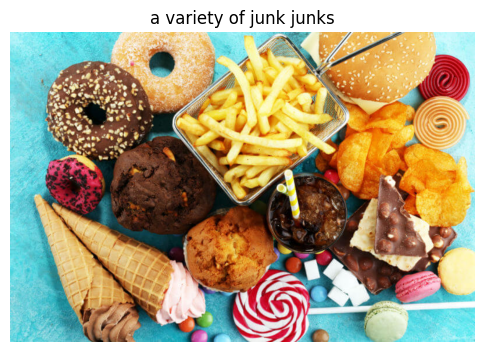

🔊 Speaking caption:


In [142]:
show_image_caption_and_audio(image_path)